# The challenge



<img src="images/Kaggle_competition_britisch_birdsongs.jpg">

# The Tasks:
 ### 1. Can you build a classifier to identify birds based on their songs?
 ### 2. Can you visualize the songs of specific birds?
 ### 3. Can you generate new birdsongs based on this data?
 
 

In [4]:

# numeric and data handeling modules
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt


# Handeling of audiofiles
import librosa
import librosa.display
import soundfile as sf
from mpl_toolkits.mplot3d import Axes3D

# ML modules
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics, model_selection, neural_network, linear_model, ensemble

import tensorflow as tf

import umap

# Diverse utilities modules
import os
from random import randint
from itertools import zip_longest
import IPython.display as apd
from time import time


In [1]:
# from itertools import zip_longest

# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# from sklearn.mixture import GaussianMixture
# from sklearn.mixture import BayesianGaussianMixture
# from sklearn.model_selection import train_test_split

# import tensorflow as tf

# from mpl_toolkits.mplot3d import Axes3D

# from sklearn import preprocessing, metrics, model_selection, neural_network, linear_model, ensemble
# import matplotlib.pyplot as plt
# from scipy import stats


## Load and read what the metadata file contains

In [6]:
df = pd.read_csv(os.path.join(os.path.abspath('.'), 
                                        "input", 
                                        "birdsong_metadata.csv"))
df.head()

file_id         genus    species   english_cname who_provided_recording  \
0   132608      Acanthis    flammea  Common Redpoll         Jarek Matusiak   
1   132611      Acanthis    flammea  Common Redpoll         Jarek Matusiak   
2    35068      Acanthis    flammea  Common Redpoll             Sander Bot   
3    82715  Acrocephalus  palustris   Marsh Warbler         Dougie Preston   
4    64685  Acrocephalus  palustris   Marsh Warbler         Dougie Preston   

          country  latitude  longitute                     type  \
0          Poland   50.7932    15.4995       female, male, song   
1          Poland   50.7932    15.4995  flight call, male, song   
2     Netherlands   52.8176     6.4326               call, song   
3  United Kingdom   60.3539    -1.2689                     Song   
4  United Kingdom   60.3539    -1.2689                     Song   

                                             license  
0  http://creativecommons.org/licenses/by-nc-sa/3.0/  
1  http://creativecommons.org/licenses/by-nc-sa/3.0/  
2  http://creativecommons.org/licenses/by-nc-nd/2.5/  
3  http://creativecommons.org/licenses/by-nc-nd/2.5/  
4  http://creativecommons.org/licenses/by-nc-nd/2.5/

In [95]:
df[df["species"] == "philomelos"]

file_id   genus     species english_cname who_provided_recording  \
258    96608  Turdus  philomelos   Song Thrush         Fraser Simpson   
259   132392  Turdus  philomelos   Song Thrush                david m   
260   146756  Turdus  philomelos   Song Thrush  David Darrell-Lambert   

            country  latitude  longitute  type  \
258  United Kingdom   51.6360    -0.3280  Song   
259  United Kingdom   54.1200    -0.5445  song   
260  United Kingdom   51.6608     0.0031  song   

                                               license  
258  http://creativecommons.org/licenses/by-nc-nd/2.5/  
259  http://creativecommons.org/licenses/by-nc-nd/3.0/  
260  http://creativecommons.org/licenses/by-nc-sa/3.0/

In [9]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   file_id                 264 non-null    int64  
 1   genus                   264 non-null    object 
 2   species                 264 non-null    object 
 3   english_cname           264 non-null    object 
 4   who_provided_recording  264 non-null    object 
 5   country                 264 non-null    object 
 6   latitude                261 non-null    float64
 7   longitute               261 non-null    float64
 8   type                    264 non-null    object 
 9   license                 264 non-null    object 
dtypes: float64(2), int64(1), object(7)
memory usage: 20.8+ KB


In [108]:
my_id = 146756
my_file_id = df[df["file_id"] == my_id]
print(f"file_id : {my_id}\ncommon bird name: {my_file_id.english_cname.values}\nscientific name {my_file_id.genus.values + ' ' + my_file_id.species.values}")

file_id : 146756
common bird name: ['Song Thrush']
scientific name ['Turdus philomelos']


##  Listening to some audio files

In [97]:
# Define the path where the audios are located
audio_path = os.path.join(os.path.abspath('.'),
                          "input",
                          "songs",
                          "songs")


In [109]:
data, samplerate = sf.read(os.path.join(audio_path, 
                      "xc"+str(my_id)+".flac"))
print(f"Size of the audio file {data.shape[0]}\nSample rate: {samplerate}");
apd.Audio(os.path.join(audio_path, 
                      "xc"+str(my_id)+".flac"))

Size of the audio file 1911461
Sample rate: 44100


##  Visualizing the audio records

In [110]:
trim_data, _ = librosa.effects.trim(data)
fig, ax = plt.subplots(figsize=(25,7))

librosa.display.waveplot(y = trim_data, sr = samplerate)

In [102]:
def process_my_raw_data(data_array, hop_l = 512):
#     n_fft = int(6.144000e+03) # FFT window size
#     hop_length = 512 # number audio of frames between STFT columns (looks like a good default)
    FFT_data = np.abs(librosa.stft(data_array, hop_length = hop_l))
    DB_data = librosa.amplitude_to_db(FFT_data, ref = np.max)
    return (DB_data)
    

In [111]:
fig, ax = plt.subplots(figsize=(25,7))

librosa.display.specshow(process_my_raw_data(trim_data), 
                         y_axis='linear', 
                         x_axis='time',
                         cmap = 'turbo')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
# plt.ylim([1024, 8200])

Text(0.5, 1.0, 'Spectrogram')

## Define a function to read and preprocess the audiofiles

In [113]:
def load_audio(path, file_id):
    # Read the aufdiofile in format .flac
    data, samplerate = sf.read(path+ "/xc"+str(file_id)+".flac")
    # determine the duration of the file
    s = len(data)/samplerate
    # compute and extract the melspectrogram
    sg = librosa.feature.melspectrogram(data, sr=samplerate, hop_length=512)#"hope_length", from the documentation -> "number of samples between successive frames"
    
    # Take mean amplitude M from frame with highest energy
    centerpoint = np.argmax(sg.mean(axis=0))
    M = sg[:,centerpoint].mean()
    
    # Filter out all frames with energy less than 5% of M
    mask = sg.mean(axis=0)>=M/20

    audio_mask = np.zeros(len(data), dtype=bool)
    for i in range(0,len(mask)):
        audio_mask[i*512:] = mask[i]
    # return the mel-spect, filtered high-pass mel-spect mask, raw data, raw_data mask and samplerate
    return sg, mask, data, audio_mask, samplerate

In [114]:
# We create a Dictionary with files_ID keys containing the arrays with the filtered record of the audiosignal
# and populate a new column to the dataframe with the lenght (duration) of the audio audiosignal

df['length'] = np.zeros(len(df))

waves = {}


for file_id in df['file_id']:
    sg, mask, data, audio_mask, sample_rate = load_audio(path = audio_path, file_id = file_id)
    waves[file_id] = data[audio_mask]
    df.loc[df['file_id'] == file_id,'length'] = len(data[audio_mask])
#     print(len(data[audio_mask])/sample_rate)

In [115]:
df.head()

file_id         genus    species   english_cname who_provided_recording  \
0   132608      Acanthis    flammea  Common Redpoll         Jarek Matusiak   
1   132611      Acanthis    flammea  Common Redpoll         Jarek Matusiak   
2    35068      Acanthis    flammea  Common Redpoll             Sander Bot   
3    82715  Acrocephalus  palustris   Marsh Warbler         Dougie Preston   
4    64685  Acrocephalus  palustris   Marsh Warbler         Dougie Preston   

          country  latitude  longitute                     type  \
0          Poland   50.7932    15.4995       female, male, song   
1          Poland   50.7932    15.4995  flight call, male, song   
2     Netherlands   52.8176     6.4326               call, song   
3  United Kingdom   60.3539    -1.2689                     Song   
4  United Kingdom   60.3539    -1.2689                     Song   

                                             license    length  
0  http://creativecommons.org/licenses/by-nc-sa/3.0/  256512.0  
1  http://creativecommons.org/licenses/by-nc-sa/3.0/   52736.0  
2  http://creativecommons.org/licenses/by-nc-nd/2.5/   47104.0  
3  http://creativecommons.org/licenses/by-nc-nd/2.5/  152576.0  
4  http://creativecommons.org/licenses/by-nc-nd/2.5/   94720.0

###  Inspect the lenght of audio files

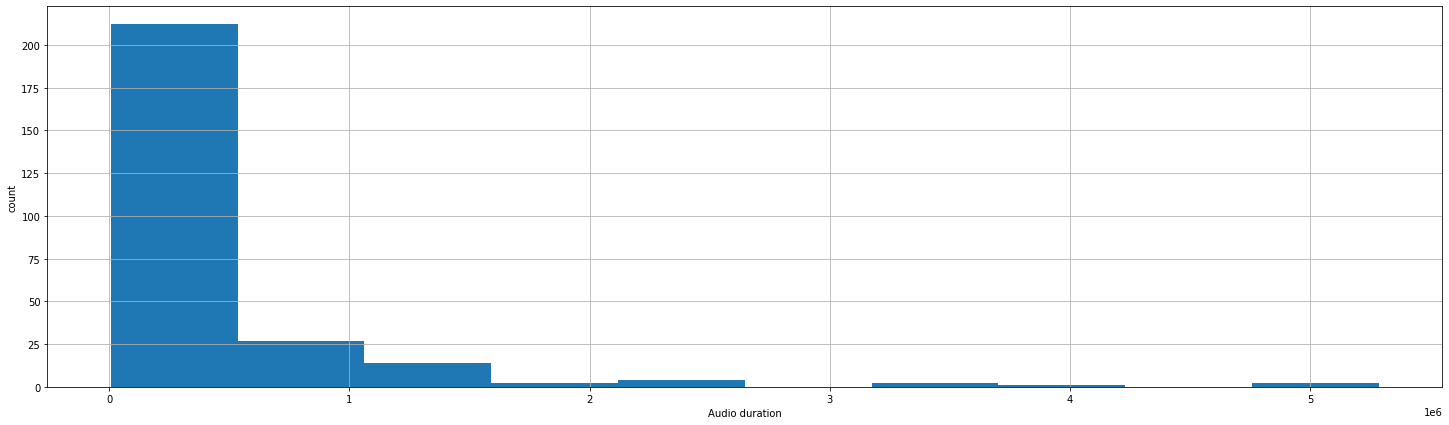

count    2.640000e+02
mean     4.307551e+05
std      6.611081e+05
min      6.144000e+03
25%      1.000960e+05
50%      2.373120e+05
75%      4.424960e+05
max      5.286262e+06
Name: length, dtype: float64

In [118]:
fig, ax = plt.subplots(figsize=(25,7))
df['length'].hist()
plt.ylabel('count')
plt.xlabel('Audio duration')
plt.show()

df['length'].describe()

In [119]:
# We set window to 6.144000e+03 frames as it's the minimum length among our audio files
df['windows'] = df['length'].apply(lambda x: int(x/6.144000e+03))
df.head()

file_id         genus    species   english_cname who_provided_recording  \
0   132608      Acanthis    flammea  Common Redpoll         Jarek Matusiak   
1   132611      Acanthis    flammea  Common Redpoll         Jarek Matusiak   
2    35068      Acanthis    flammea  Common Redpoll             Sander Bot   
3    82715  Acrocephalus  palustris   Marsh Warbler         Dougie Preston   
4    64685  Acrocephalus  palustris   Marsh Warbler         Dougie Preston   

          country  latitude  longitute                     type  \
0          Poland   50.7932    15.4995       female, male, song   
1          Poland   50.7932    15.4995  flight call, male, song   
2     Netherlands   52.8176     6.4326               call, song   
3  United Kingdom   60.3539    -1.2689                     Song   
4  United Kingdom   60.3539    -1.2689                     Song   

                                             license    length  windows  
0  http://creativecommons.org/licenses/by-nc-sa/3.0/  256512.0       41  
1  http://creativecommons.org/licenses/by-nc-sa/3.0/   52736.0        8  
2  http://creativecommons.org/licenses/by-nc-nd/2.5/   47104.0        7  
3  http://creativecommons.org/licenses/by-nc-nd/2.5/  152576.0       24  
4  http://creativecommons.org/licenses/by-nc-nd/2.5/   94720.0       15

In [120]:
#compute the sum of total windows for species
df.groupby(["genus",'species'])['windows'].sum().to_frame().sort_values("windows")

windows
genus           species               
Motacilla       flava               20
Perdix          perdix              23
Calidris        alpina              37
Sylvia          curruca             38
Muscicapa       striata             40
...                                ...
Locustella      fluviatilis        671
Chroicocephalus ridibundus         777
Acrocephalus    schoenobaenus     1049
Caprimulgus     europaeus         1050
Alauda          arvensis          1731

[88 rows x 1 columns]

In [121]:
# We'll consider the genus + species as the label 
# We use 20 windows per genus + species to have a balanced data set

n_windows = df.groupby(["genus",'species'])['windows'].sum().min()
n_windows

20

In [122]:
# We create all windows for each file and partition them by species

windows = {}

for file_id in df['file_id']:
    wave = waves[file_id]
    species = df[df['file_id']==file_id]['genus'].values[0] + "_" + df[df['file_id']==file_id]['species'].values[0]
    if species not in windows:
        windows[species] = []
    for i in range(0, int(len(wave)/6.144000e+03)):
        windows[species].append(wave[i:int(i+6.144000e+03)])
        



In [123]:
# We randomly pick 20 windows for each species

# Save other samples for testing

windows_fixed = {}
windows_fixed_test = {}

for species in windows.keys():
    windows_fixed[species] = []
    windows_fixed_test[species] = []
    ws = windows[species]
    index = np.random.choice(len(ws), n_windows, replace=False)
    for i in range(0, len(ws)):
        if i in index:
            windows_fixed[species].append(ws[i])
        else:
            windows_fixed_test[species].append(ws[i])

# Spectral centroid
The spectral centroid is a measure used in digital signal processing to characterise a spectrum. It indicates where the center of mass of the spectrum is located. Perceptually, it has a robust connection with the impression of brightness of a sound.

*Source: Wikipedia*

## Visualizing the centroids for a given Window

In [135]:
# Take a given window from the fixed Window_20
my_window_indx = 19
my_species_name = "Turdus_philomelos"
my_window = windows_fixed[my_species_name][my_window_indx]

No handles with labels found to put in legend.
/Users/rubencito/.pyenv/versions/3.8.8/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/rubencito/.pyenv/versions/3.8.8/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/rubencito/.pyenv/versions/3.8.8/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


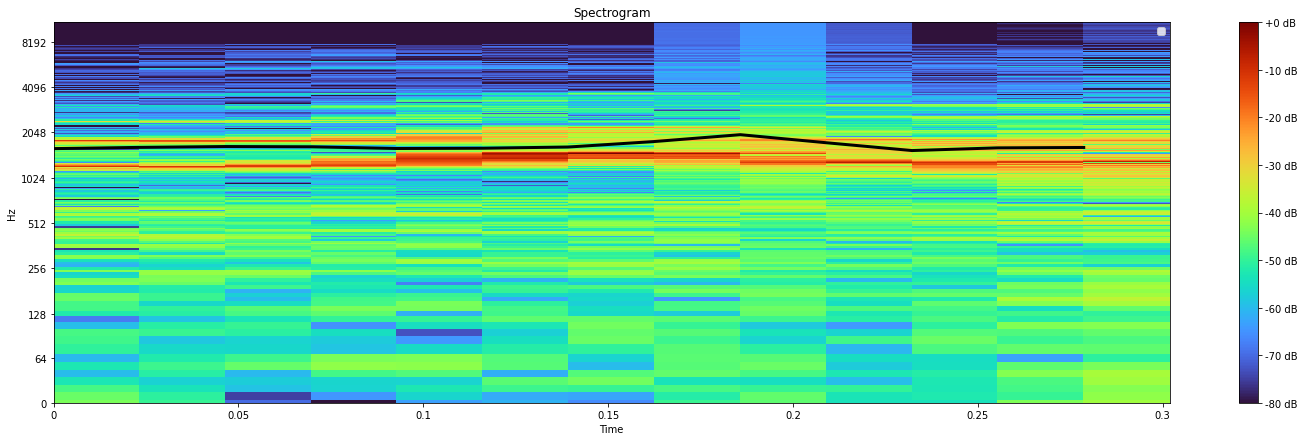

In [175]:
# Compute short time Fourier transforms and stract magnitude (S) component
S, _ = librosa.magphase(librosa.stft(y=my_window))
# # # compute the centroid
cent = librosa.feature.spectral_centroid(S=S)
# # # fix the time to be in s
times = librosa.times_like(cent)


fig, ax = plt.subplots(figsize=(25,7))
ax.legend(loc='upper right')
ax.set(title='Spectrogram')

librosa.display.specshow(process_my_raw_data(my_window),
                         y_axis='log', 
                         x_axis='time',
                         cmap = 'turbo')
plt.colorbar(format='%+2.0f dB')
ax.plot(times, cent.T, label='Spectral centroid', color='k', linewidth= 3)



# Chroma feature
In Western music, the term chroma feature or chromagram closely relates to the twelve different pitch classes. Chroma-based features, which are also referred to as "pitch class profiles", are a powerful tool for analyzing music whose pitches can be meaningfully categorized (often into twelve categories) and whose tuning approximates to the equal-tempered scale. One main property of chroma features is that they capture **harmonic** and **melodic** characteristics of music, while being robust to changes in timbre and instrumentation. 

*Source: Wikipedia*

## Visualizing the chroma spectrum for a given Window



[Text(0.5, 1.0, 'Chromagram')]

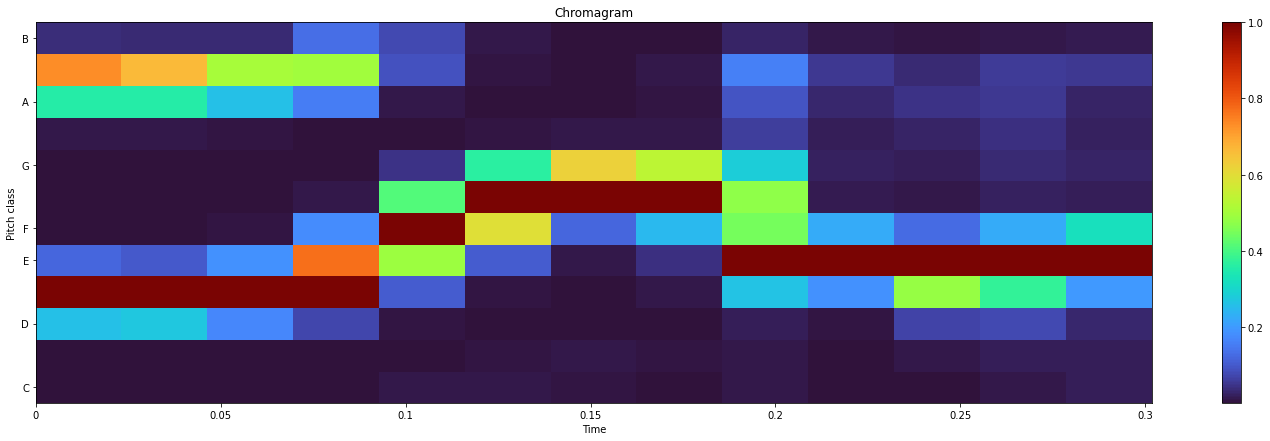

In [186]:
fig, ax = plt.subplots(figsize=(25,7))

chroma = librosa.feature.chroma_stft(y=my_window, sr=sample_rate)
img = librosa.display.specshow(chroma, 
                               y_axis='chroma', 
                               x_axis='time',
                               cmap = 'turbo',
                               ax=ax)

fig.colorbar(img, ax=ax)

ax.set(title='Chromagram')

#  Extracting features

In [ ]:
# Extract Features from fixed Window (20)

new_dataset = pd.DataFrame()# this is the same as train.csv dataset

for species in windows_fixed.keys():
    for i in range(0,n_windows):
        data_point = {'species':species.split('_')[1], 'genus':species.split('_')[0]}
        spec_centroid = librosa.feature.spectral_centroid(windows_fixed[species][i])[0]
        chroma = librosa.feature.chroma_stft(windows_fixed[species][i], sample_rate)
        for j in range(0,13):
            data_point['spec_centr_'+str(j)] = spec_centroid[j]
            for k in range(0,12):
                data_point['chromogram_'+str(k)+"_"+str(j)] = chroma[k,j]
        new_dataset = new_dataset.append(data_point,ignore_index=True)

new_dataset["id"] =np.arange(len(new_dataset))
new_dataset.head()

/Users/rubencito/.pyenv/versions/3.8.8/lib/python3.8/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [271]:
# Extract Features from Window for test

new_dataset_test = pd.DataFrame()# this is the same as test.csv

for species in windows_fixed_test.keys():
    for i in range(0,len(windows_fixed_test[species])):
        data_point = {'species':species.split('_')[1], 'genus':species.split('_')[0]}
        spec_centroid = librosa.feature.spectral_centroid(windows_fixed_test[species][i])[0]
        chroma = librosa.feature.chroma_stft(windows_fixed_test[species][i], sample_rate)
        for j in range(0,13):
            data_point['spec_centr_'+str(j)] = spec_centroid[j]
            for k in range(0,12):
                data_point['chromogram_'+str(k)+"_"+str(j)] = chroma[k,j]
        new_dataset_test = new_dataset_test.append(data_point,ignore_index=True)

new_dataset_test["id"] =np.arange(len(new_dataset_test))
new_dataset_test.head()

/Users/rubencito/.pyenv/versions/3.8.8/lib/python3.8/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


chromogram_0_0  chromogram_0_1  chromogram_0_10  chromogram_0_11  \
0        1.000000        0.945011         0.749241         0.714737   
1        0.982724        0.826884         0.768729         0.702757   
2        1.000000        0.945205         0.744401         0.716860   
3        1.000000        0.904057         0.749178         0.708311   
4        0.997944        0.832392         0.765386         0.704275   

   chromogram_0_12  chromogram_0_2  chromogram_0_3  chromogram_0_4  \
0         0.704973        0.311386        0.881971        0.280575   
1         0.662904        0.328242        0.924370        0.311240   
2         0.701898        0.315170        0.885456        0.275877   
3         0.676811        0.318977        0.899720        0.284723   
4         0.655724        0.331064        0.927524        0.307601   

   chromogram_0_5  chromogram_0_6  ...  spec_centr_2  spec_centr_3  \
0        0.519973        0.170108  ...   2731.690852   2611.073050   
1        0.492785        0.167188  ...   2731.110902   2610.496832   
2        0.519047        0.170131  ...   2730.815328   2610.216159   
3        0.506305        0.168488  ...   2730.666134   2610.077572   
4        0.492226        0.167480  ...   2730.515996   2609.940116   

   spec_centr_4  spec_centr_5  spec_centr_6  spec_centr_7  spec_centr_8  \
0   2702.003239   2675.278371   2817.586465   2708.632712   2738.029229   
1   2702.711165   2675.828996   2817.996189   2707.371617   2739.432407   
2   2703.054777   2676.112022   2818.189758   2706.744518   2740.128437   
3   2703.223991   2676.255550   2818.283776   2706.431856   2740.475063   
4   2703.391481   2676.400498   2818.375970   2706.119790   2740.820758   

   spec_centr_9  species  id  
0   2688.206937  flammea   0  
1   2686.417165  flammea   1  
2   2685.521405  flammea   2  
3   2685.073264  flammea   3  
4   2684.624943  flammea   4  

[5 rows x 172 columns]

# Beging of Data exploration

In [2]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [3]:
if os.path.exists('data'):
    train_df = pd.read_csv(os.path.join(os.path.abspath('.'), 
                                        "data", 
                                        "train.csv"))
    test_df = pd.read_csv(os.path.join(os.path.abspath('.'), 
                                        "data", 
                                        "test.csv"))

In [4]:
print(f"Shape of the train_df: {train_df.shape} \nShape of the test_df: {test_df.shape}")

Shape of the train_df: (1760, 172) 
Shape of the test_df: (16626, 172)


In [5]:
#Capturing the columns names
features = list(train_df.columns)

### We note that labels "id", "genus" and "species" are present

In [6]:
features.remove("id")
features.remove("genus")
features.remove("species")

In [7]:
train_df.species.unique()

array(['flammea', 'palustris', 'schoenobaenus', 'scirpaceus', 'caudatus',
       'arvensis', 'pratensis', 'trivialis', 'apus', 'canadensis',
       'alpina', 'europaeus', 'carduelis', 'familiaris', 'chloris',
       'ridibundus', 'monedula', 'livia', 'oenas', 'palumbus', 'corax',
       'corone', 'frugilegus', 'canorus', 'caeruleus', 'urbicum', 'major',
       'martius', 'calandra', 'citrinella', 'schoeniclus', 'rubecula',
       'coelebs', 'atra', 'gallinago', 'chloropus', 'glandarius',
       'stellata', 'ostralegus', 'rustica', 'torquilla', 'lagopus',
       'argentatus', 'cannabina', 'fluviatilis', 'curvirostra',
       'megarhynchos', 'apiaster', 'aguimp', 'flava', 'striata',
       'oriolus', 'domesticus', 'montanus', 'perdix', 'ater', 'apivorus',
       'colchicus', 'phoenicurus', 'collybita', 'sibilatrix', 'trochilus',
       'pica', 'viridis', 'apricaria', 'squatarola', 'modularis',
       'pyrrhula', 'regulus', 'europaea', 'decaocto', 'turtur', 'aluco',
       'vulgaris', 'at

'There are aparently 85 species in the training dataset'

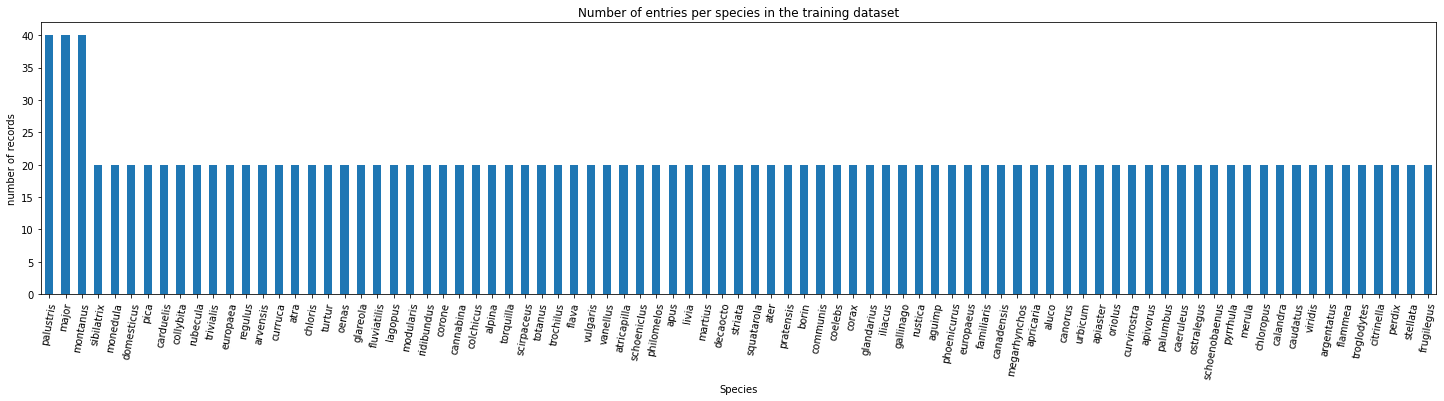

In [8]:
fig, ax = plt.subplots(figsize=(25,5))
train_df['species'].value_counts().plot.bar(ax=ax)
plt.title("Number of entries per species in the training dataset" )
plt.xlabel('Species')
plt.xticks(rotation=80)
plt.ylabel('number of records');
plt.show
f"There are aparently {len(train_df.species.unique())} species in the training dataset"

##  It looks like there are more than 20 records for species
but closer inpection shows that in fact there are 20 records per each. We must cont the full name for a specie, that is the genus + species

In [9]:
train_df['full_sp_name'] = train_df['genus'] + '_' + train_df['species']
test_df['full_sp_name'] = test_df['genus'] + '_' + test_df['species']

but in fact there are 88 species
and actually 20 records per specie


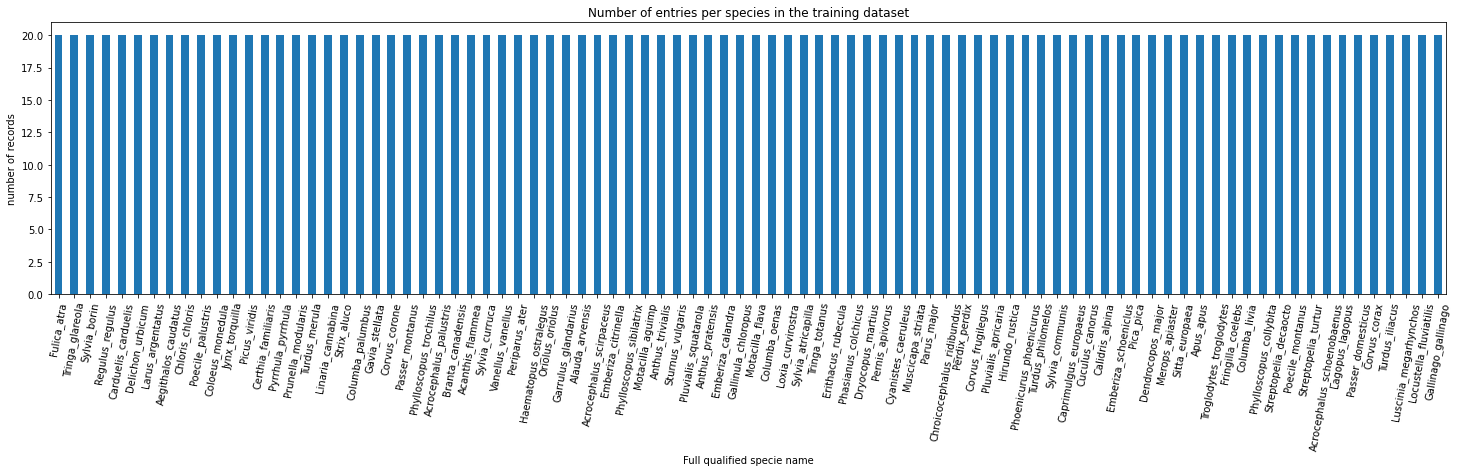

In [10]:
fig, ax = plt.subplots(figsize=(25,5))
train_df['full_sp_name'].value_counts().plot.bar(ax=ax)
plt.title("Number of entries per species in the training dataset" )
plt.xlabel('Full qualified specie name')
plt.xticks(rotation=80)
plt.ylabel('number of records');
plt.show
print(f"but in fact there are {len(train_df.full_sp_name.unique())} species\nand actually 20 records per specie" )

## Exlporing the test df

but in fact there are 87 and diverse number of records per specie


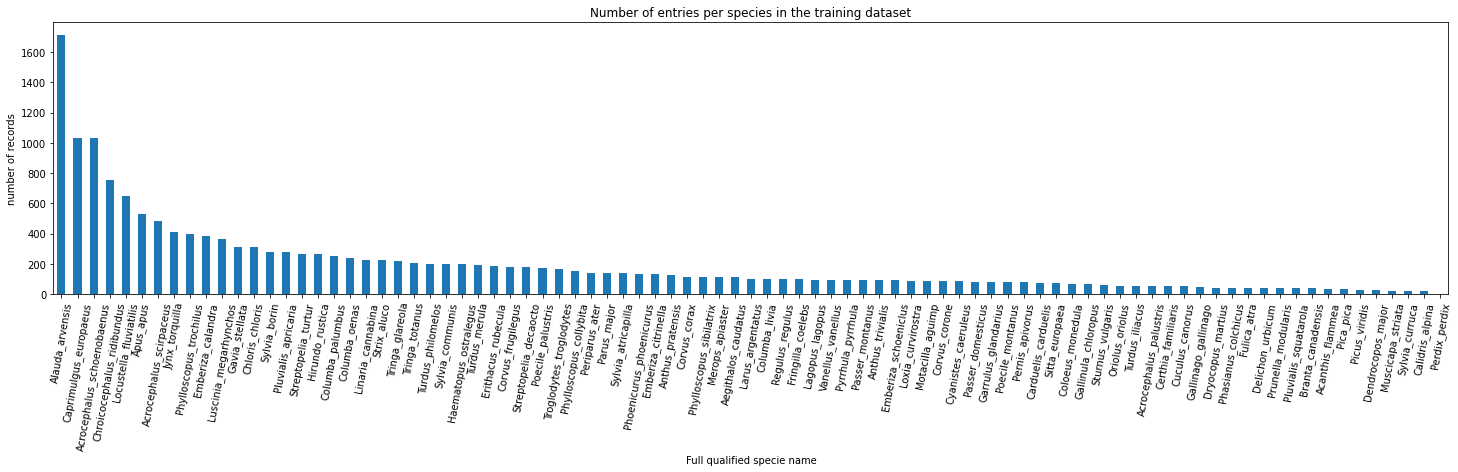

In [11]:
fig, ax = plt.subplots(figsize=(25,5))
test_df['full_sp_name'].value_counts().plot.bar(ax=ax)
plt.title("Number of entries per species in the training dataset" )
plt.xlabel('Full qualified specie name')
plt.xticks(rotation=80)
plt.ylabel('number of records');
plt.show
print(f"but in fact there are {len(test_df.full_sp_name.unique())} and diverse number of records per specie" )

## Scale/standarize dataset and encode the label

In [14]:
scaler = preprocessing.StandardScaler()# Declare an instance of the transformer/scaler
scaler.fit(train_df[features])# Compute the transformation

train_df[features] = pd.DataFrame(scaler.transform(train_df[features]), columns=features)# Transform (scale) the features on the train_df
test_df[features] = pd.DataFrame(scaler.transform(test_df[features]), columns=features)# Transform (scale) the features on the test_df

##  We take split half of the test dataframe for later validation

In [15]:
X_val, X_test, Y_val, Y_test = train_test_split(test_df[features], test_df['full_sp_name'], test_size=0.5, random_state=1000, stratify=test_df['full_sp_name'])

###  We will use now as:
   1. Validation  dataset-> `x_val`, `y_val`: we will run the model and asses accuraca on the model training with this dataset.
   2. Test dataset -> `x_test`, `y_test`: The model will never see this dataset until the end to see how perfomr with unkonw data.
   3. And the training dataset remains is taking below from the original dataframe.

In [16]:
# Define the training dataset.
x_train = train_df[features].values

y_train_raw = train_df['full_sp_name'].values
le = preprocessing.LabelEncoder()# *** Help normalize labels (numeric or in this case strings) such that they contain only values between 0 and n_classes-1

y_train = le.fit_transform(y_train_raw)# Transform autput labels to numeric values.


# Define the test and validation datasets.

x_test = X_test.values
y_raw_test = Y_test.values

y_test = le.transform(y_raw_test)



x_val = X_val.values
y_val_test = Y_val.values

y_val = le.transform(y_val_test)

In [17]:
print(f"shape of train data: x_train = {x_train.shape}, y_train = {y_train.shape}\nshape of test data: x_test = {x_test.shape}, y_test = {y_test.shape}\nshape of val data: x_val = {x_val.shape}, y_val = {y_val.shape}")

shape of train data: x_train = (1760, 169), y_train = (1760,)
shape of test data: x_test = (8313, 169), y_test = (8313,)
shape of val data: x_val = (8313, 169), y_val = (8313,)


In [18]:
test_df.shape

(16626, 173)

## Use PCA to show the dataset in a reduced space dimension

Explained variance ratio:  [0.198 0.115 0.106 0.064 0.045 0.038 0.028 0.022 0.020 0.019 0.017 0.016
 0.015 0.014 0.014 0.012 0.011 0.010 0.010 0.009 0.009 0.008 0.008 0.008
 0.007 0.007 0.006 0.006 0.006 0.006 0.005 0.005 0.005 0.005 0.005 0.004
 0.004 0.004 0.004 0.004 0.004 0.003 0.003 0.003 0.003 0.003 0.003 0.003
 0.003 0.003 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002
 0.002 0.002 0.002 0.002 0.002 0.002 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000

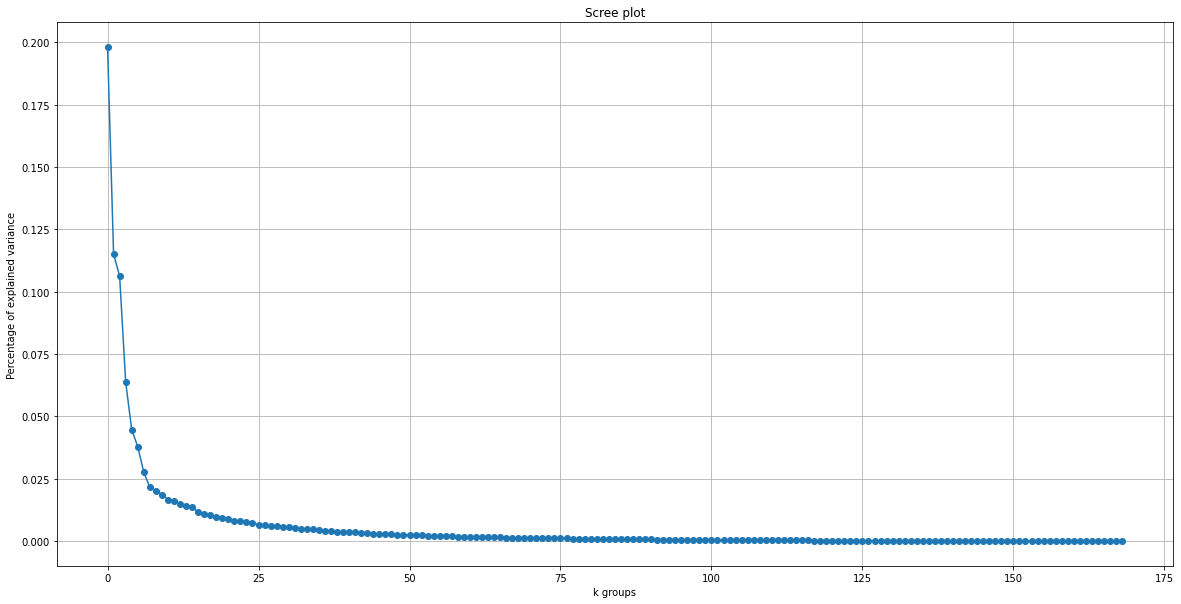

In [15]:
pca=PCA()
pca.fit(X)
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(pca.explained_variance_ratio_,'-o')
plt.title('Scree plot')
plt.ylabel('Percentage of explained variance')
plt.xlabel('k groups')
plt.grid()
print('Explained variance ratio: ' ,pca.explained_variance_ratio_)
plt.show()

## Embedding the firts two components of the PCA

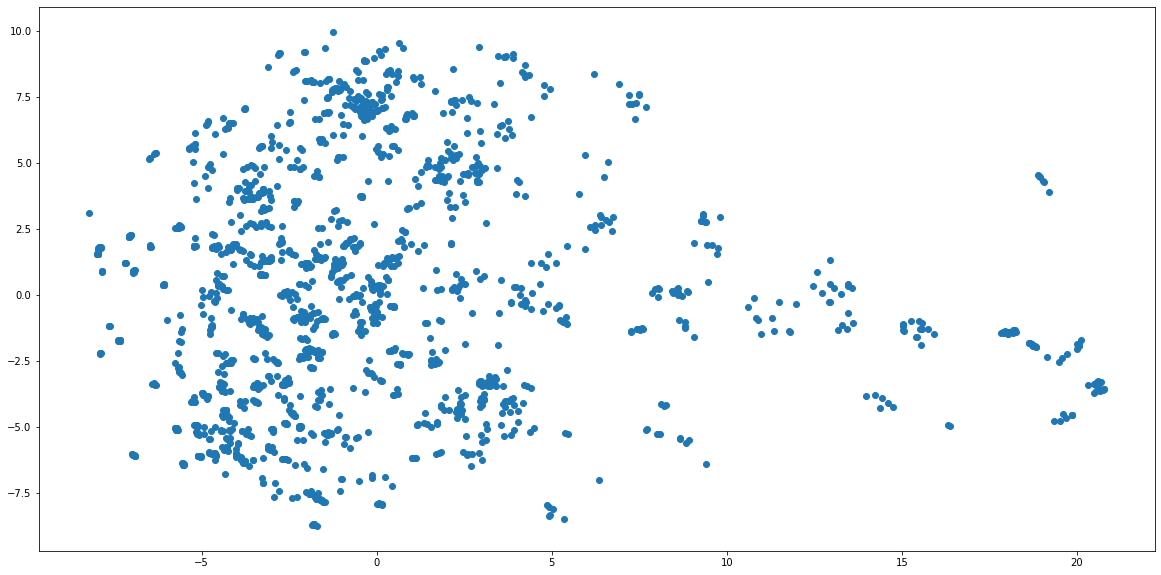

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
X_pca = pca.transform(X)
plt.plot(X_pca[:,0],X_pca[:,1],'o')

## Use umap (UMAP) to show the dataset in a reduced space dimension

#### Use a helper function to visualize various parameters

In [17]:
def draw_umap(n_neighbors=15, min_dist=0.1, 
              n_components=2, metric='euclidean', 
              title='', 
              plot_indx1 = 4, plot_indx2 = 4, plot_grid_size = 1, 
              font_s = 20,
              scat_s = 10):
    
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        random_state=9991
        
    )
    
    t0 = time()
    u = fit.fit_transform(X);
    t1 = time()

    if n_components == 1:
        ax = fig.add_subplot(plot_indx1, plot_indx2, plot_grid_size)
        ax.scatter(u[:,0], range(len(u)))
    if n_components == 2:
        ax = fig.add_subplot(plot_indx1, plot_indx2, plot_grid_size)
        ax.scatter(u[:,0], u[:,1], s=scat_s)
    if n_components == 3:
        ax = fig.add_subplot(plot_indx1, plot_indx2, plot_grid_size, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2],  s=scat_s)
    plt.title(title + f"\nelapsed time: {t1 - t0:.2f}", fontsize=font_s)


### Exploring different neighbors and minimal distance (hyperparameter landscape)

#### Extractting 2 components

In [24]:
# Run me only locally
components = 2
neigbords = [5, 10, 50, 100, 200]
distance = [0.1, 0.25, 0.5, 0.8, 0.99]

fig_Count = 0
nrows, ncols = len(neigbords), len(distance)

fig = plt.figure(figsize=(60, 60))

for indx1, n  in enumerate(neigbords, start=1):
    for indx2, d in enumerate(distance, start=1):
        fig_Count += 1
#         print(f"this is my neigb: {i} and this is my distance {j} and index1: {indx1} and index2: {indx2}")
        draw_umap(min_dist=d, 
                     n_neighbors=n,
                     n_components= components, 
                     title=f'min_dist = {d} and neigbords {n}',
                     plot_indx1 = nrows, plot_indx2 = ncols, plot_grid_size = fig_Count)

fig.tight_layout(pad=3)

## Use TSNE to show the dataset in a reduced space dimension

#### Use a helper function to visualize various parameters

In [18]:
def draw_TSNE(n_perplex=125, 
              learn_rate=200, 
              early_exag=4.0,
              init='pca',
              n_itera=1000, 
              metric='euclidean', 
              verbo=100,
              title='', 
              plot_indx1 = 4, plot_indx2 = 4, plot_grid_size = 1, 
              font_s = 20,
              scat_s = 10):
    
    
    fit = TSNE(perplexity=n_perplex, 
               learning_rate=learn_rate, 
               early_exaggeration=early_exag,
               init=init,
               n_iter=n_itera, 
               random_state=9999991, 
               metric=metric, 
               verbose=0 )
    
    t0 = time()
    u = fit.fit_transform(X);
    t1 = time()

    ax = fig.add_subplot(plot_indx1, plot_indx2, plot_grid_size)
    ax.scatter(u[:,0], u[:,1], s=scat_s)
    
    plt.title(title + f"\nelapsed time: {t1 - t0:.2f}", fontsize=font_s)


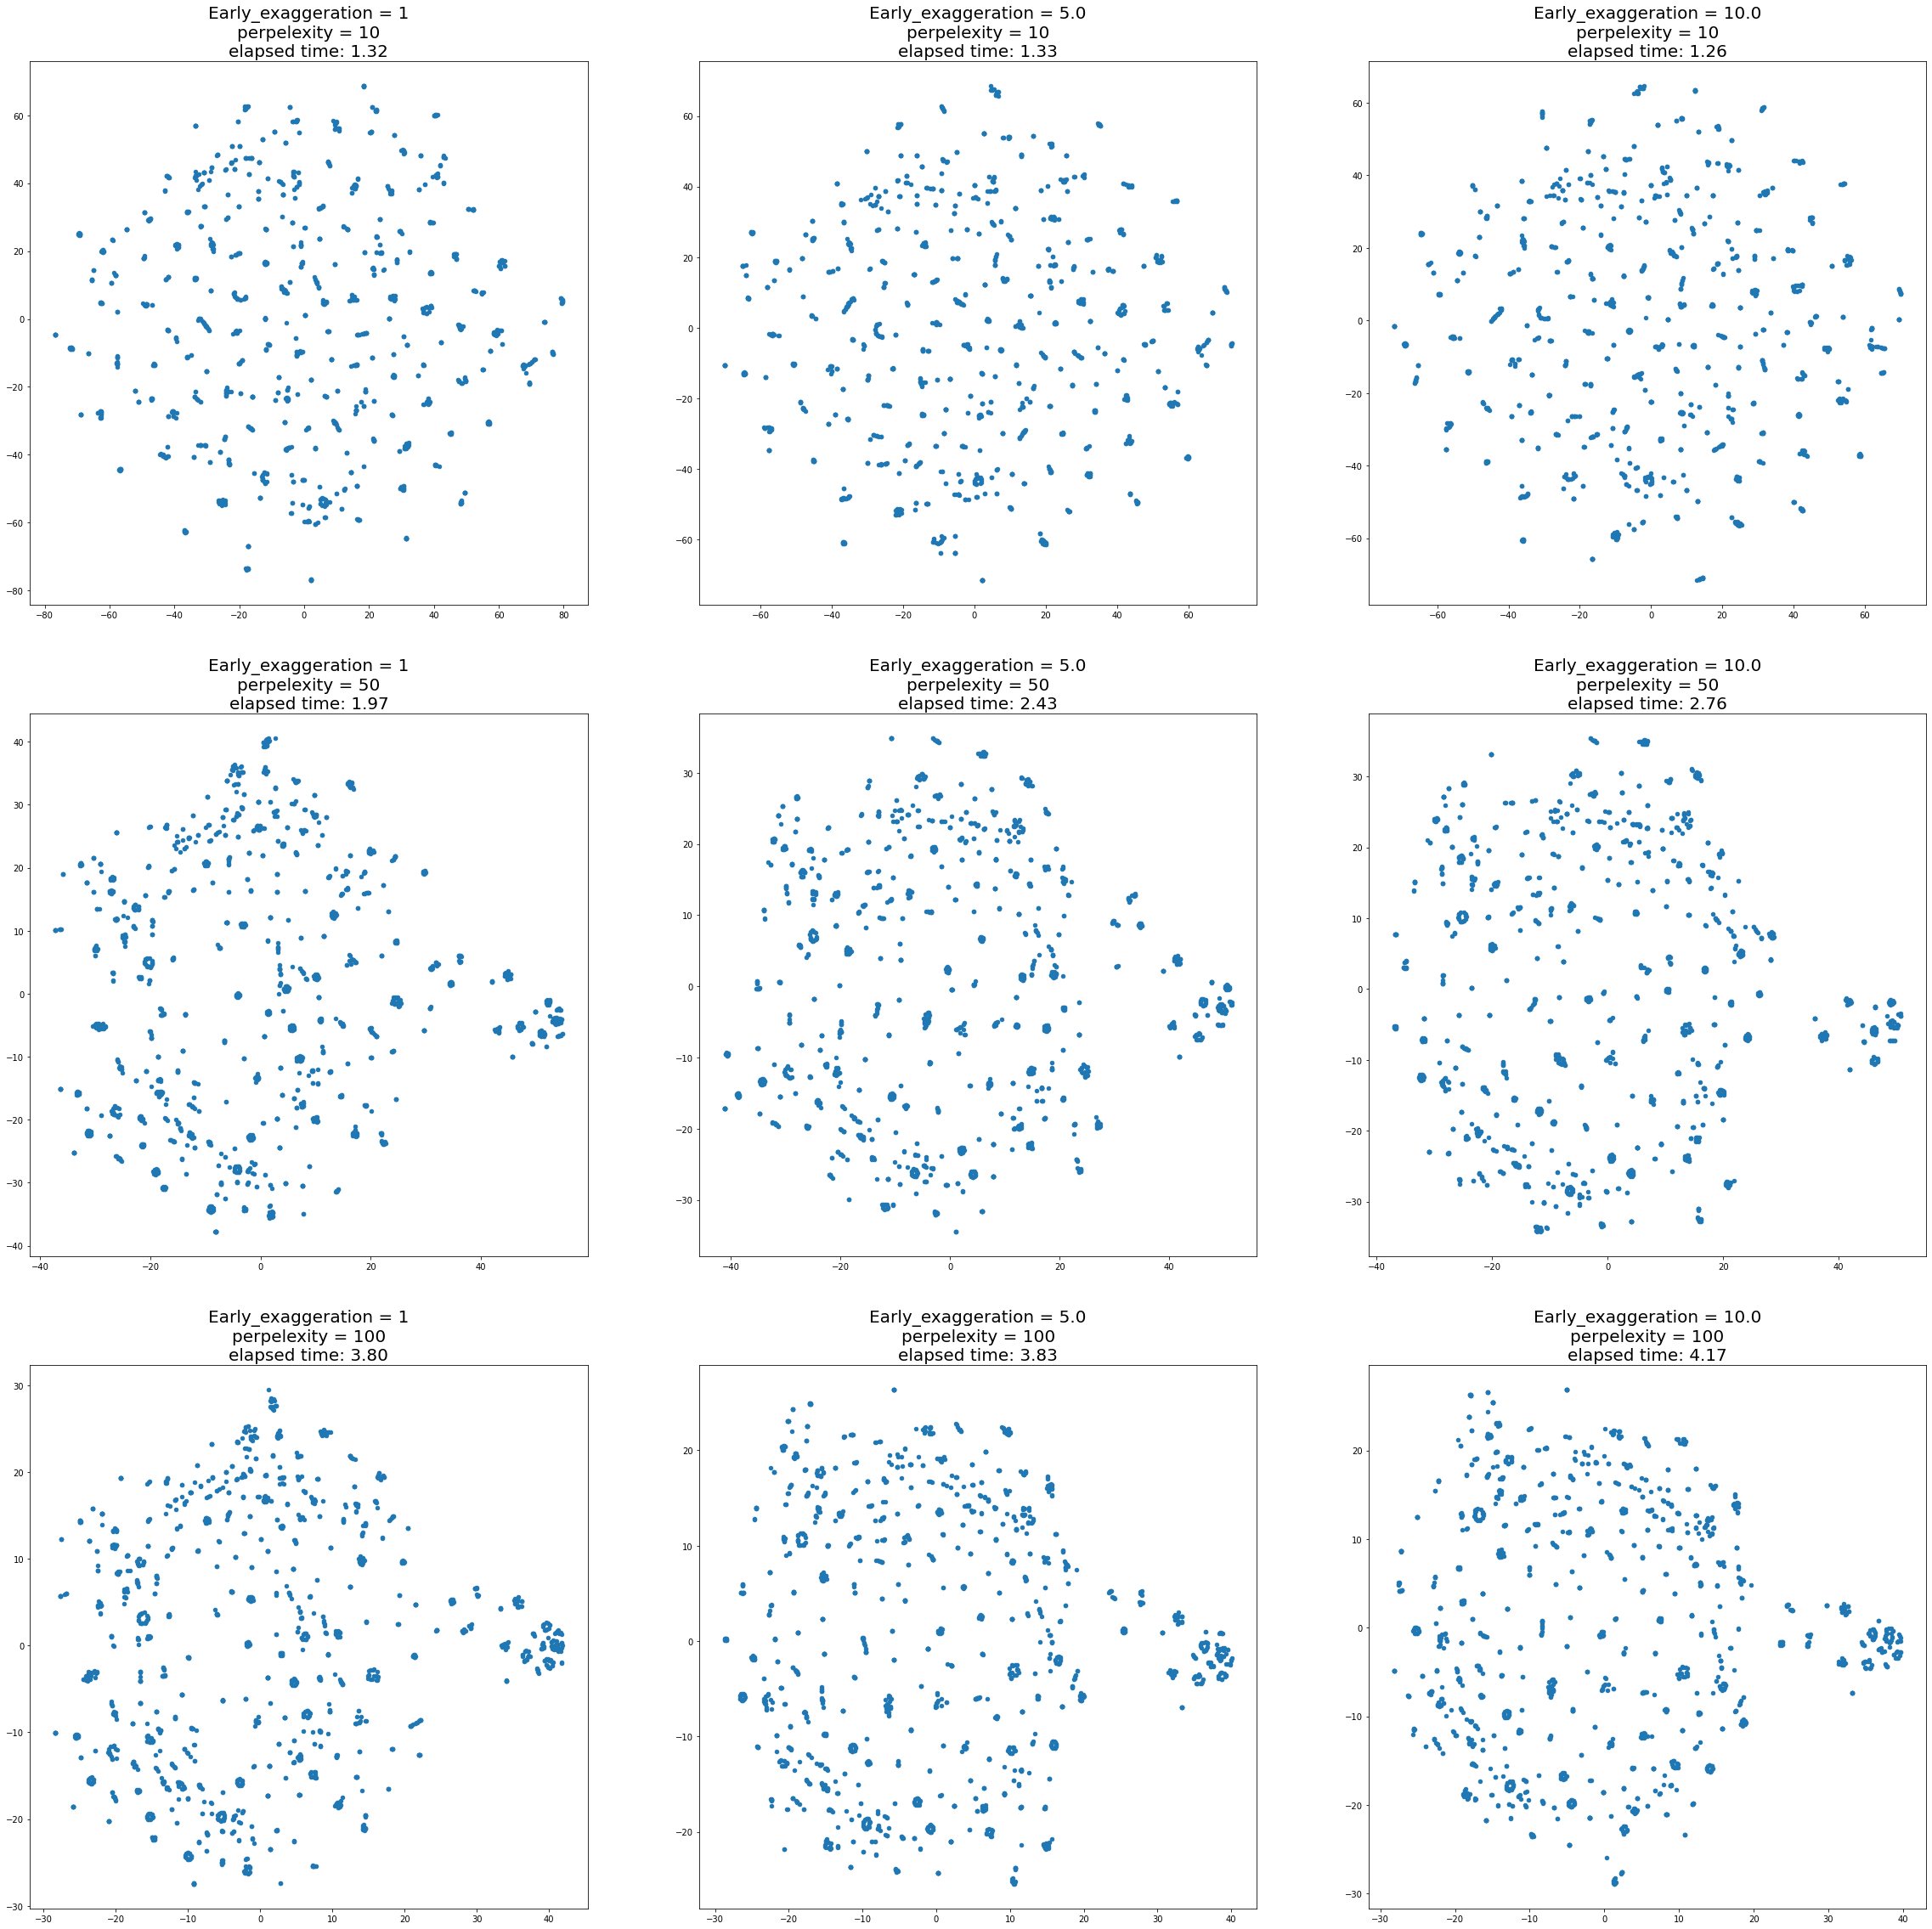

In [19]:
# Run me only locally

learning_rate=200
itera=500

perplexity=[10, 50, 100]
exagg=[1, 5.0, 10.0]



fig_Count = 0
nrows, ncols = len(perplexity), len(exagg)

fig = plt.figure(figsize=(40, 40))

for indx1, p  in enumerate(perplexity, start=1):
    for indx2, e in enumerate(exagg, start=1):
        fig_Count += 1
#         print(f"this is my neigb: {i} and this is my distance {j} and index1: {indx1} and index2: {indx2}")
        draw_TSNE(n_perplex=p, 
                  learn_rate=learning_rate, 
                  early_exag=e,
                  n_itera=itera,
                  title=f'Early_exaggeration = {e}\nperpelexity = {p}',
                  plot_indx1 = nrows, plot_indx2 = ncols, plot_grid_size = fig_Count,
                  font_s = 20, scat_s = 20)



## Exploring the numbers of clusters via K-means

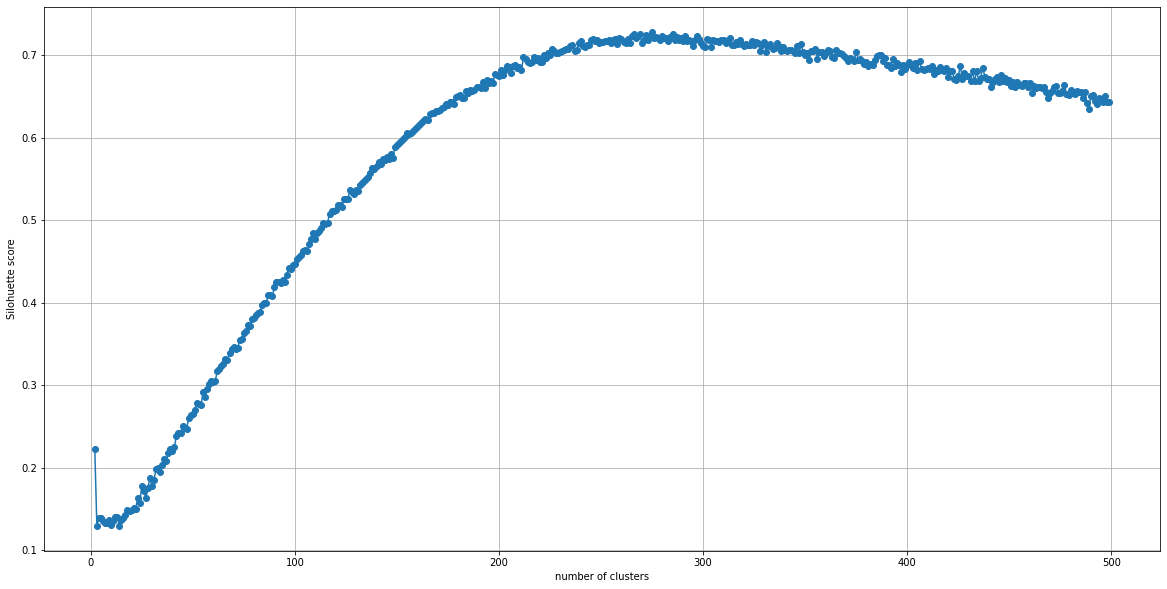

In [20]:
# Run me only locally

plt.figure(figsize=(20, 10))
scores=[]
clusters = 500


for itrial in range(2,clusters):
#     print('Number of clusters considered: ',itrial)
    clusterer = KMeans(n_clusters=itrial, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    score=silhouette_score(X,cluster_labels)
    scores.append(score)
    
plt.grid()
plt.plot(np.arange(len(scores))+2,np.array(scores),'-o')
plt.ylabel('Silohuette score');
plt.xlabel('number of clusters');

### Assesing Gaussian mixture for classification

In [ ]:
# # No need to run this code
# n_rows, n_cols = list(range(1, 5)), list(range(1, 5))
# start, end = 80, 96

# aic=[]
# bic=[]
# sil=[]

# scat_s = 20
# font_s = 20
# fig = plt.figure(figsize=(60, 60))

# for indx, i_comp in enumerate(range(start, end), start = 1):
#     ax = fig.add_subplot(len(n_rows), len(n_cols), indx)
    
#     clf =  GaussianMixture(n_components=i_comp, covariance_type='full')
    
    
# #     u = clf.fit_transform(X);
    
#     t0 = time()
#     clf.fit(X)
#     cluster_labels=clf.predict(X)
#     t1 = time()
    
#     ax.scatter(X[:,0], X[:,1], c = cluster_labels, s = scat_s)
#     plt.title(f"components: {i_comp}\nelapsed time :{t1 - t0:.2f}\nIC: {clf.aic(X):.2f}\nBIC: {clf.bic(X):.2f}\nSilhouette_score: {silhouette_score(X,cluster_labels):.2f}", fontsize = font_s)
    


In [ ]:
# plt.figure(figsize=(20, 10))
# scat_s = 20
# font_s = 20
# i_comp = 85
    
# clf =  GaussianMixture(n_components=i_comp, covariance_type='full')
    
    
# # u = clf.fit_transform(X);
    
# t0 = time()
# clf.fit(X)
# cluster_labels=clf.predict(X)
# t1 = time()


# plt.scatter(X[:,0], X[:,1], c = cluster_labels, s = scat_s)
# plt.title(f"components: {i_comp}\nelapsed time :{t1 - t0:.2f}\nIC: {clf.aic(X):.2f}\nBIC: {clf.bic(X):.2f}\nSilhouette_score: {silhouette_score(X,cluster_labels):.2f}", fontsize = font_s)

### Plot the Gaussian mixture performance

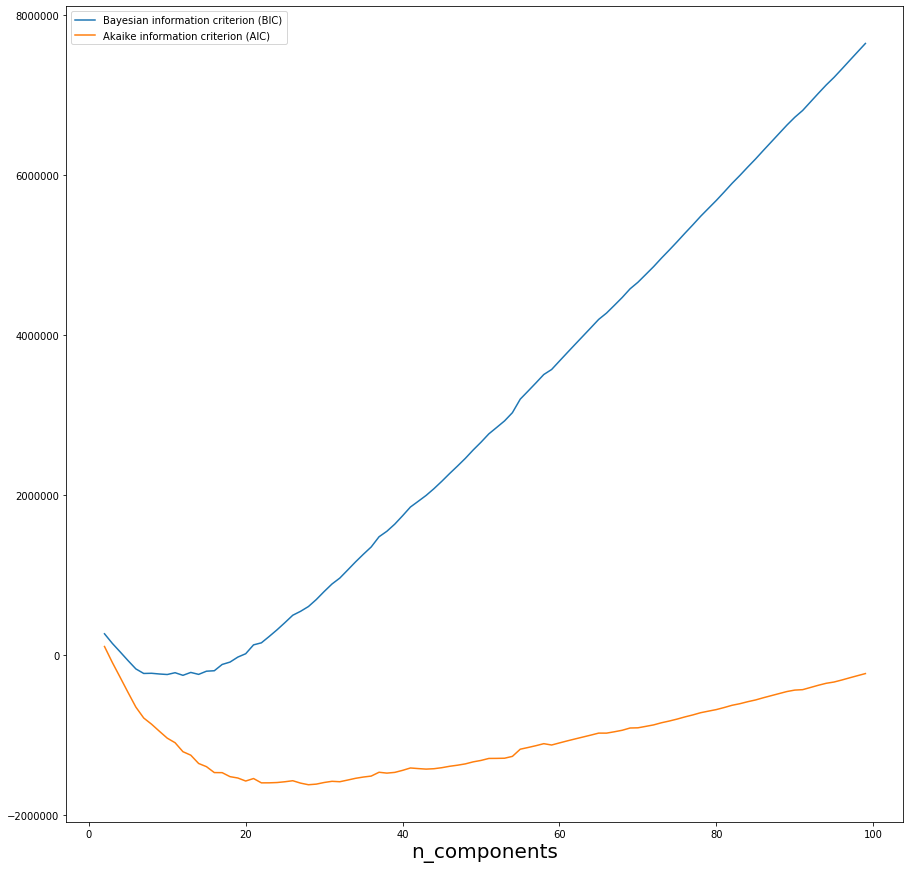

In [77]:
plt.figure(figsize=(15, 15))
scat_s = 20
font_s = 20

n_components = np.arange(2, 100, 1)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='Bayesian information criterion (BIC)')
plt.plot(n_components, [m.aic(X) for m in models], label='Akaike information criterion (AIC)')
plt.legend(loc='best')
plt.xlabel('n_components', fontsize = font_s);



### Build and compare 3 models:
1. logisteic regression, 
2. Random Forest
3. Forward neural network


In [27]:
scaler = preprocessing.StandardScaler()# Declare an instance of the transformer/scaler
scaler.fit(train_df[features])# Compute the transformation

train_df[features] = pd.DataFrame(scaler.transform(train_df[features]), columns=features)# Transform (scale) the features on the train_df
test_df[features] = pd.DataFrame(scaler.transform(test_df[features]), columns=features)# Transform (scale) the features on the test_df

X = train_df[features].values
y_raw = train_df['full_sp_name'].values

le = preprocessing.LabelEncoder()# *** Help normalize labels (numeric or in this case strings) such that they contain only values between 0 and n_classes-1

y = le.fit_transform(y_raw)# Transform autput labels to numeric values.

X_test = test_df[features].values
y_raw_test = test_df['full_sp_name'].values

y_test = le.transform(y_raw_test)



In [29]:
# As we can see there are very noticeable clusters let's see if some model can learn to distinguish between the species

sss = model_selection.StratifiedShuffleSplit(n_splits=5,test_size=0.2)

log_reg_accs = []
log_reg_ap = []
log_reg_f1 = []
log_reg_preds = np.zeros((5,len(X_test)))

rand_forest_accs = []
rand_forest_ap = []
rand_forest_f1 = []
rand_forest_preds = np.zeros((5,len(X_test)))

nn_accs = []
nn_ap = []
nn_f1 = []
nn_preds = np.zeros((5,len(X_test)))

i = 0

for train_index, val_index in sss.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    log_reg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto')
    log_reg.fit(X_train, y_train)
    y_val_pred = log_reg.predict(X_val)
    log_reg_accs.append(metrics.accuracy_score(y_val_pred, y_val))
    log_reg_preds[i] = log_reg.predict(X_test)
    
    rand_forest = ensemble.RandomForestClassifier(n_estimators=100)
    rand_forest.fit(X_train, y_train)
    y_val_pred = rand_forest.predict(X_val)
    rand_forest_accs.append(metrics.accuracy_score(y_val_pred, y_val))
    rand_forest_preds[i] = rand_forest.predict(X_test)
    
    
    nn = neural_network.MLPClassifier(activation='relu',hidden_layer_sizes=[128,128])
    nn.fit(X_train, y_train)
    y_val_pred = nn.predict(X_val)
    nn_accs.append(metrics.accuracy_score(y_val_pred, y_val))
    nn_preds[i] = nn.predict(X_test)
    
    i += 1
    
print("Accuracy of Logistic Regression on validation set: ", np.mean(log_reg_accs))
print("Accuracy of Random Forest on validation set: ", np.mean(rand_forest_accs))
print("Accuracy of Feed Forward Neural Network on validation set: ", np.mean(nn_accs))

/Users/rubencito/.pyenv/versions/3.8.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rubencito/.pyenv/versions/3.8.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Accuracy of Logistic Regression on validation set:  0.9710227272727273
Accuracy of Random Forest on validation set:  0.9818181818181818
Accuracy of Feed Forward Neural Network on validation set:  0.9693181818181819


# Building a neural network with tensor flow

In [52]:
for i in range(5, 20):
    print(2**i)

32
64
128
256
512
1024
2048
4096
8192
16384
32768
65536
131072
262144
524288


In [19]:
my_bird_song_model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(2048, activation='relu', name="layer1", input_shape=(169,)),
#     tf.keras.layers.Dense(2048, activation='relu', name="layer3"),
#     tf.keras.layers.Dense(4096, activation='relu', name="layer4"),
#     tf.keras.layers.Dense(1024, activation='relu', name="layer5"),
#     tf.keras.layers.Dense(512, activation='relu', name="layer6"),
#     tf.keras.layers.Dense(256, activation='relu', name="layer7"),
    tf.keras.layers.Dense(88, activation='softmax', name="layer8")
    ])

my_bird_song_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
my_bird_song_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 2048)              348160    
_________________________________________________________________
layer8 (Dense)               (None, 88)                180312    
Total params: 528,472
Trainable params: 528,472
Non-trainable params: 0
_________________________________________________________________


### Model training

In [21]:
save_path = 'save/nn_model_bird_class_{epoch}.ckpt'
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, save_weights_only=True)

hist = my_bird_song_model.fit(x_train, y_train,
                              epochs=20, batch_size=150, 
                              validation_data=(x_val, y_val),#this has to be a tupple () not a list [] 
                              callbacks=[save_callback])

Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 3.5126 - accuracy: 0.3374 - val_loss: 1.2526 - val_accuracy: 0.8060
Epoch 2/20
12/12 [==============================] - 0s 14ms/step - loss: 0.8673 - accuracy: 0.8746 - val_loss: 0.6014 - val_accuracy: 0.8745
Epoch 3/20
12/12 [==============================] - 0s 14ms/step - loss: 0.2941 - accuracy: 0.9623 - val_loss: 0.3163 - val_accuracy: 0.9460
Epoch 4/20
12/12 [==============================] - 0s 14ms/step - loss: 0.1493 - accuracy: 0.9797 - val_loss: 0.2894 - val_accuracy: 0.9447
Epoch 5/20
12/12 [==============================] - 0s 14ms/step - loss: 0.0650 - accuracy: 0.9930 - val_loss: 0.2221 - val_accuracy: 0.9574
Epoch 6/20
12/12 [==============================] - 0s 14ms/step - loss: 0.0419 - accuracy: 0.9973 - val_loss: 0.1738 - val_accuracy: 0.9706
Epoch 7/20
12/12 [==============================] - 0s 14ms/step - loss: 0.0299 - accuracy: 0.9997 - val_loss: 0.1612 - val_accuracy: 0.9751
Epoch 8/20
12

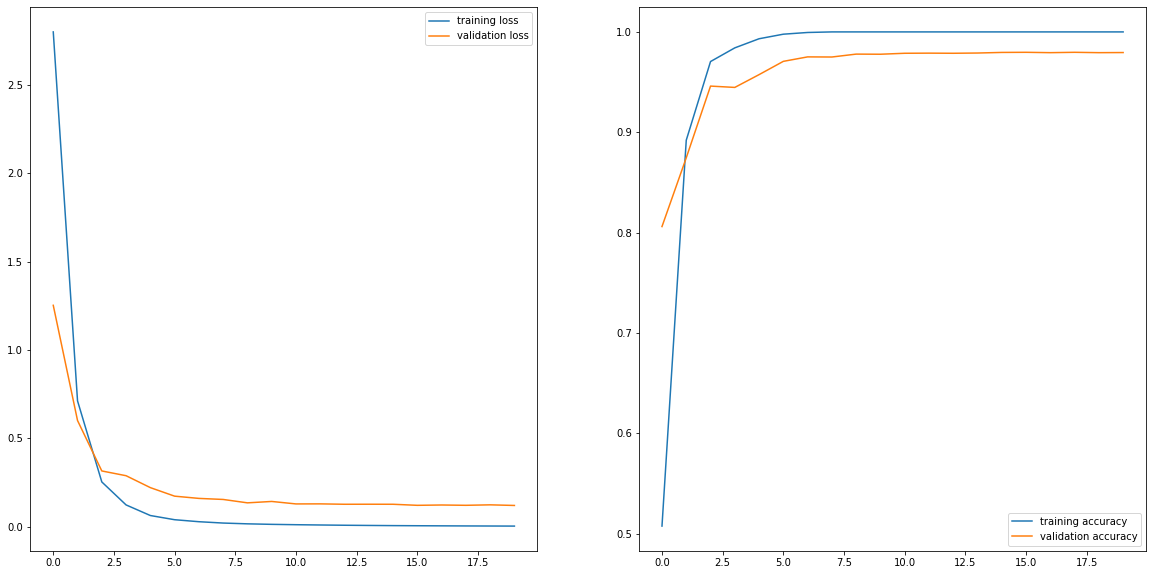

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='upper right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

In [167]:
my_classes_dic = {}
for n, i in enumerate(le.classes_, start = 0):
    print(n, i )


0 Acanthis_flammea
1 Acrocephalus_palustris
2 Acrocephalus_schoenobaenus
3 Acrocephalus_scirpaceus
4 Aegithalos_caudatus
5 Alauda_arvensis
6 Anthus_pratensis
7 Anthus_trivialis
8 Apus_apus
9 Branta_canadensis
10 Calidris_alpina
11 Caprimulgus_europaeus
12 Carduelis_carduelis
13 Certhia_familiaris
14 Chloris_chloris
15 Chroicocephalus_ridibundus
16 Coloeus_monedula
17 Columba_livia
18 Columba_oenas
19 Columba_palumbus
20 Corvus_corax
21 Corvus_corone
22 Corvus_frugilegus
23 Cuculus_canorus
24 Cyanistes_caeruleus
25 Delichon_urbicum
26 Dendrocopos_major
27 Dryocopus_martius
28 Emberiza_calandra
29 Emberiza_citrinella
30 Emberiza_schoeniclus
31 Erithacus_rubecula
32 Fringilla_coelebs
33 Fulica_atra
34 Gallinago_gallinago
35 Gallinula_chloropus
36 Garrulus_glandarius
37 Gavia_stellata
38 Haematopus_ostralegus
39 Hirundo_rustica
40 Jynx_torquilla
41 Lagopus_lagopus
42 Larus_argentatus
43 Linaria_cannabina
44 Locustella_fluviatilis
45 Loxia_curvirostra
46 Luscinia_megarhynchos
47 Merops_apia

## Pick a random entry from the unseen test dataset and make prediction

In [21]:
print(f"shape of train data: x_train = {x_train.shape}, y_train = {y_train.shape}\nshape of test data: x_test = {x_test.shape}, y_test = {y_test.shape}\nshape of val data: x_val = {x_val.shape}, y_val = {y_val.shape}")

shape of train data: x_train = (1760, 169), y_train = (1760,)
shape of test data: x_test = (8313, 169), y_test = (8313,)
shape of val data: x_val = (8313, 169), y_val = (8313,)


In [23]:
my_test_value = randint(0, 8313)
print(f"The random entry is {my_test_value}\nand correspond to {le.inverse_transform([y_test[my_test_value]])[0]}")

The random entry is 2399
and correspond to Columba_palumbus


In [24]:
my_prediction = my_bird_song_model.predict(x_test[[my_test_value], :])

May be define a function that return the 3 hits with the highest probabilities?....

In [28]:
my_prediction

array([[0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.999, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]], dtype=float32)

In [25]:
for n, i in enumerate(my_prediction[0], start=0):
    print(n, round(i, 3))

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.999
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.001
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
